In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data,color,feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import nltk


nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Data Exploration

In [3]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = '/content/drive/MyDrive/AiOG/IMDB Dataset.csv'

# Load the dataset into a Pandas DataFrame
dataset = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset to check its structure
print(dataset.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Data Cleaning

In [4]:
import re

# Function to remove HTML tags from a string
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Apply the function to the 'text' column
dataset['review'] = dataset['review'].apply(remove_html_tags)
# Convert the 'text' column to lowercase
dataset['review'] = dataset['review'].str.lower()
# Function to remove punctuation and special characters from a string
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Apply the function to the 'text' column
dataset['review'] = dataset['review'].apply(remove_punctuation)


Tokenizing

In [5]:
from nltk.tokenize import word_tokenize


# Function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)


# Apply the function to the 'text' column
dataset['tokens'] = dataset['review'].apply(tokenize_text)


from keras.preprocessing.text import Tokenizer


# Create a tokenizer and fit it on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['review'])


# Convert the text tokens to sequences of integers
dataset['sequences'] = tokenizer.texts_to_sequences(dataset['tokens'])


Label encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'sentiment' column
dataset['label'] = label_encoder.fit_transform(dataset['sentiment'])

# Display the mapping of original labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'negative': 0, 'positive': 1}


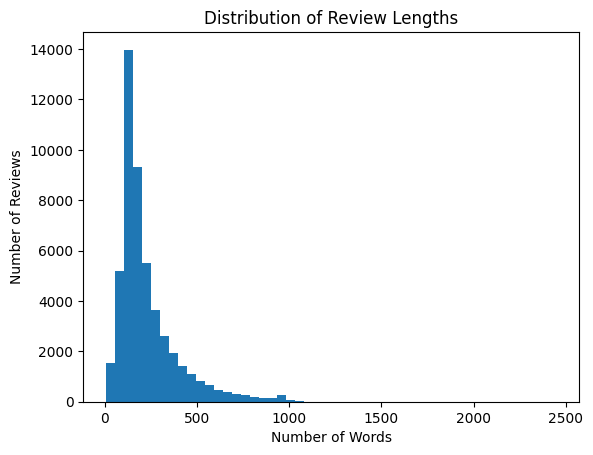

In [7]:
# Analyze the distribution of review lengths
review_lengths = dataset['review'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.hist(review_lengths, bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.show()


Data Splitting

In [8]:
from sklearn.model_selection import train_test_split

# Define the features (X) and labels (y)
X = dataset['review']
y = dataset['label']

# Split the data into training and temporary (validation + test) sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)

# Display the sizes of the resulting sets
print("Training set size:", len(X_train_temp))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 15000
Validation set size: 7000
Test set size: 28000


vocab size determination

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Create a Tokenizer instance
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_temp)

# Get the word index dictionary
word_index = tokenizer.word_index

# Determine the vocab_size
vocab_size = len(word_index)


Sentiment Analysis

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 1000  # Adjust based on your dataset
embedding_dim = 50  # can also use pre-trained embeddings like GloVe or Word2Vec


# Set sequence_length to 1000
sequence_length = 1000

# Tokenize the text data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_temp)

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_temp)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=sequence_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=sequence_length, padding='post')

# Create the CNN model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))

# Convolutional layers

model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='valid'))

model.add(GlobalMaxPooling1D())

# Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()
# Loading training data from a previous step



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          50000     
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          32128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [11]:
print(X_train_temp.shape)


(15000,)


Size determination

In [12]:
print("X_train_pad shape:", X_train_pad.shape)
print("y_train_temp shape:", y_train_temp.shape)
print("Example X_train_pad:", X_train_pad[0])

X_train_pad shape: (15000, 1000)
y_train_temp shape: (15000,)
Example X_train_pad: [  2   1 116   5 792   1   1   1  11   7 938 186   2 230  19 194 118 104
  47   4 654  98  15   4  77   1   6 142  43   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 

Model Training

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam



# Define and compile the model
model = Sequential()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 64
epochs = 10
# Print the data types and shapes
print("Data type of X_train_pad:", X_train_pad.dtype)
print("Data type of y_train_temp:", y_train_temp.dtype)
print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of y_train_temp:", y_train_temp.shape)

# Adding layers
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Printing the input shape of the first layer in the model
print("Model Input Shape:", model.layers[0].input_shape)

# Training the model
history = model.fit(X_train_pad, y_train_temp, epochs=epochs, batch_size=batch_size, validation_data=(X_val_pad, y_val))





Data type of X_train_pad: int32
Data type of y_train_temp: int64
Shape of X_train_pad: (15000, 1000)
Shape of y_train_temp: (15000,)
Model Input Shape: (None, 1000)
Epoch 1/10
235/235 [==============================] - 115s 481ms/step - loss: 0.5776 - accuracy: 0.6794 - val_loss: 0.4093 - val_accuracy: 0.8120
Epoch 2/10
235/235 [==============================] - 96s 408ms/step - loss: 0.3581 - accuracy: 0.8458 - val_loss: 0.3351 - val_accuracy: 0.8520
Epoch 3/10
235/235 [==============================] - 93s 397ms/step - loss: 0.2748 - accuracy: 0.8878 - val_loss: 0.3300 - val_accuracy: 0.8544
Epoch 4/10
235/235 [==============================] - 104s 441ms/step - loss: 0.2130 - accuracy: 0.9212 - val_loss: 0.3308 - val_accuracy: 0.8584
Epoch 5/10
235/235 [==============================] - 99s 421ms/step - loss: 0.1561 - accuracy: 0.9468 - val_loss: 0.3586 - val_accuracy: 0.8589
Epoch 6/10
235/235 [==============================] - 103s 437ms/step - loss: 0.1010 - accuracy: 0.9710 - va

Plotting the Learning Curve

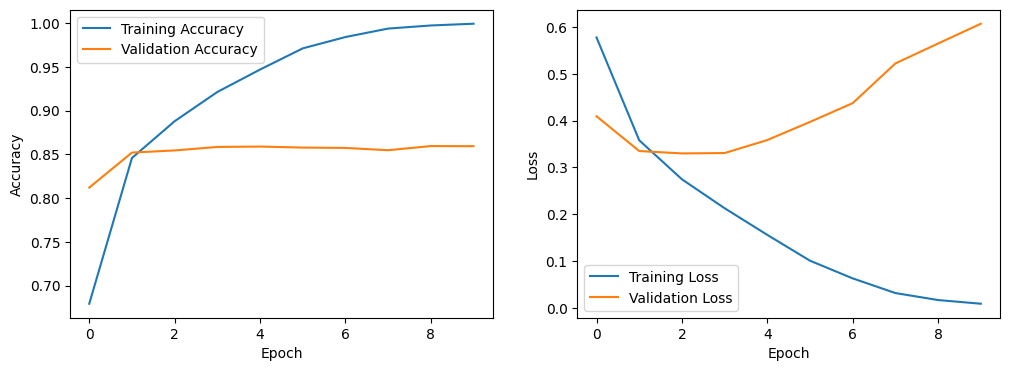

In [14]:
import matplotlib.pyplot as plt

# Access training history from the 'history' object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


875/875 [==============================] - 45s 52ms/step - loss: 0.6166 - accuracy: 0.8548
Test Loss: 0.6166
Test Accuracy: 0.8548


Confusion Matrix

875/875 [==============================] - 44s 50ms/step


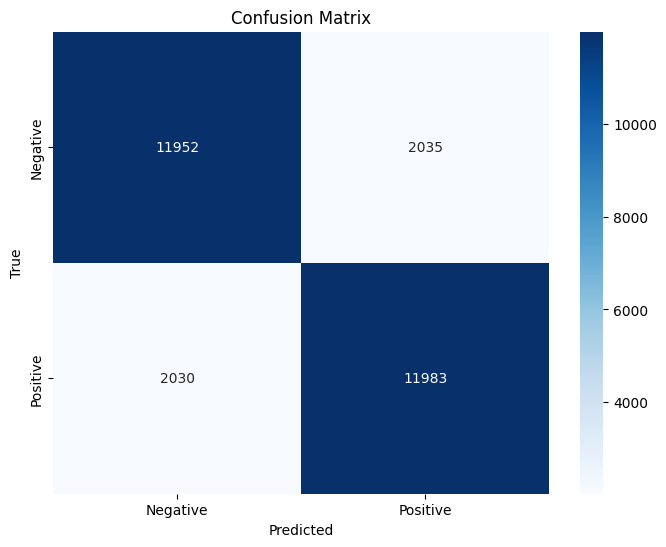

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gettting predictions on the test set
y_pred = model.predict(X_test_pad)

# Converting predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Classification report

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on the test set
test_predictions = model.predict(X_test_pad)
# Convert predictions to binary values (0 or 1)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Calculate confusion matrix, precision, recall, and F1 score
conf_matrix = confusion_matrix(y_test, test_predictions_binary)
classification_rep = classification_report(y_test, test_predictions_binary)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


875/875 [==============================] - 45s 51ms/step
Confusion Matrix:
[[11952  2035]
 [ 2030 11983]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     13987
           1       0.85      0.86      0.85     14013

    accuracy                           0.85     28000
   macro avg       0.85      0.85      0.85     28000
weighted avg       0.85      0.85      0.85     28000



Attempt at implementing an API

In [ ]:
'''import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import text_to_word_sequence

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_review(review):
    # Lowercasing
    review = review.lower()

    # Tokenization
    words = word_tokenize(review)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Joining the words back into a sentence
    processed_review = ' '.join(filtered_words)
    processed_review = ' '.join(text_to_word_sequence(processed_review))

    return processed_review


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
'''
from IPython.display import display, HTML
from ipywidgets import widgets
from keras.preprocessing.sequence import pad_sequences
import numpy as np



import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import text_to_word_sequence

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Load sentiment analysis model
model = load_model('sentiment_analysis_model.h5')

def preprocess_review(review, tokenizer):
    # Lowercasing
    review = review.lower()

    # Tokenization
    words = word_tokenize(review)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Optionally, can also use Keras text_to_word_sequence for further processing
    processed_review = ' '.join(text_to_word_sequence(' '.join(filtered_words)))

    # Converting the text to a sequence of integers using the tokenizer
    processed_sequence = tokenizer.texts_to_sequences([processed_review])

    return processed_sequence

tokenizer = tokenize_text(text)

def predict_sentiment(review, tokenizer):
    processed_sequence = preprocess_review(review, tokenizer)
    padded_sequence = pad_sequences(processed_sequence, maxlen=1000, padding='post')
    prediction = model.predict(np.array(padded_sequence))
    sentiment = 'Positive' if prediction[0, 0] > 0.5 else 'Negative'
    return sentiment

def predict_sentiment(review, tokenizer):
    tokens = tokenize_text(review)
    sequences = tokenizer.texts_to_sequences([tokens])
    padded_sequence = pad_sequences(sequences, maxlen=1000, padding='post')
    prediction = model.predict(np.array(padded_sequence))
    sentiment = 'Positive' if prediction[0, 0] > 0.5 else 'Negative'
    return sentiment


def on_submit(b):
    review = text_input.value
    sentiment = predict_sentiment(review)
    output_label.value = f"Sentiment: {sentiment}"

# input text box and submit button
text_input = widgets.Textarea(
    value='',
    placeholder='Enter your review here',
    description='Review:',
    layout={'height': '100px', 'width': '400px'}
)
sentiment = predict_sentiment(review, tokenizer)

submit_button = widgets.Button(description="Submit")
submit_button.on_click(on_submit)

# an output label
output_label = widgets.Label(value="Sentiment: ")

# widgets
display(text_input, submit_button, output_label)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NameError: ignored

Dataset Citation

@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}